In [1]:
!git clone https://github.com/NataliaVrabcova/assessment-1-neural-networks

Cloning into 'assessment-1-neural-networks'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 42 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 2.19 MiB | 2.52 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
import pandas as pd

# Adjust the path to match your repository structure
data = pd.read_csv('/content/assessment-1-neural-networks/healthcare_noshows_appointments.csv')

# Verify the dataset is loaded
print(data.head())

      PatientId  AppointmentID Gender ScheduledDay AppointmentDay  Age  \
0  2.987250e+13        5642903      F   2016-04-29     2016-04-29   62   
1  5.589978e+14        5642503      M   2016-04-29     2016-04-29   56   
2  4.262962e+12        5642549      F   2016-04-29     2016-04-29   62   
3  8.679512e+11        5642828      F   2016-04-29     2016-04-29    8   
4  8.841186e+12        5642494      F   2016-04-29     2016-04-29   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA        False          True     False       False   
1    JARDIM DA PENHA        False         False     False       False   
2      MATA DA PRAIA        False         False     False       False   
3  PONTAL DE CAMBURI        False         False     False       False   
4    JARDIM DA PENHA        False          True      True       False   

   Handcap  SMS_received  Showed_up  Date.diff  
0    False         False       True          0  
1    False        

In [3]:
# Inspect the distribution of the target variable
class_distribution = data['Showed_up'].value_counts()

# Print the results
print("Class Distribution:")
print(class_distribution)

Class Distribution:
Showed_up
True     85307
False    21680
Name: count, dtype: int64


The dataset is highly unbalanced, with significantly more "True" (showed up) labels than "False" (did not show up).
This imbalance can lead to a bias in the model, where it predominantly predicts "True" since it is the majority class.

We randomly sample 21,680 data points from the "True" class to match the "False" class count.

In [13]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = data[data['Showed_up'] == True]
minority_class = data[data['Showed_up'] == False]

# Downsample the majority class to match the minority class
downsampled_majority_class = resample(majority_class,
                                      replace=False,    # sample without replacement
                                      n_samples=21680,  # number of samples to match the minority class
                                      random_state=42)  # reproducibility

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([downsampled_majority_class, minority_class])


By downsampling, we create a balanced dataset with equal representation of both classes, allowing the model to learn more effectively and make more accurate predictions across all classes.

In [5]:
# Importing libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

Preprocessing the Data

In [6]:
# Selecting features and target variable
X = balanced_data.drop(['Showed_up', 'PatientId', 'AppointmentID'], axis=1)
y = balanced_data['Showed_up']

# Encoding categorical variables
X = pd.get_dummies(X, drop_first=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature Selection: Excludes columns not needed for model training, such as IDs and the target variable itself.
Categorical Encoding: Converts categorical data into a numerical format suitable for neural network training.
Data Splitting: Divides the data into training and testing sets to validate the model’s performance.
Feature Scaling: Normalizes the data to ensure that all features contribute equally to the learning process.

Defining the architecture of the neural network:

In [21]:
# Defining the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(32, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

Input Layer: Defines the input shape based on the number of features after
preprocessing.

Hidden Layers: Uses ReLU activation for hidden layers (64 and 32 neurons), This is common for capturing complex patterns.

Dropout: Helps prevent overfitting by randomly setting some of the input units to zero at each update during training.

Output Layer: A sigmoid activation function is appropriate for binary classification tasks (showed up or not).

**The Adam** optimizer was chosen due to its adaptability and efficiency in handling sparse gradients. The default learning rate of 0.001 was used, as it generally works well for a wide range of tasks and often provides a good starting point for optimization. This ensures stable and efficient convergence without the need for extensive fine-tuning.

Train the model with your preprocessed data:

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # monitor validation loss
                              patience=5,          # number of epochs with no improvement to wait before stopping
                              restore_best_weights=True) # restores the model to the best weights


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5956 - loss: 0.7567 - val_accuracy: 0.7750 - val_loss: 0.4714
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7579 - loss: 0.5095 - val_accuracy: 0.8200 - val_loss: 0.4090
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7729 - loss: 0.4514 - val_accuracy: 0.8350 - val_loss: 0.3960
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.4359 - val_accuracy: 0.8450 - val_loss: 0.3852
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8497 - loss: 0.3839 - val_accuracy: 0.8500 - val_loss: 0.3885
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8645 - loss: 0.3879 - val_accuracy: 0.8600 - val_loss: 0.3949
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.4121 - val_accuracy: 0.8600 - val_loss: 0.3730
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8486 - loss: 0.3687 - val_accuracy: 0.8600 - val_loss

Epochs: Early stopping was implemented to monitor validation loss and halt training when performance stalled.

Batch Size: smaller batch sizes can aid in faster convergence, whereas larger sizes can provide more accurate updates. We selected 32 as a batch size, as it is a commonly used standard that balances computational efficiency, convergence speed, and model performance.
Validation Data: Monitors the model’s performance on a holdout set to prevent overfitting.

Evaluate the model’s performance:

In [23]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.8600


Accuracy Calculation: Measures the proportion of correct predictions on the test set. A higher accuracy indicates a better-performing model.

Evaluate the model on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6600 - loss: 0.6031


Test Loss:
  This value indicates the average error (or loss) of the model when it made predictions on the test data. A lower loss generally means that the model made fewer mistakes.

Test Accuracy:
  This metric shows the proportion of correct predictions (true positives + true negatives) out of the total predictions on the test set. A value closer to 1 indicates better performance.



**Backpropagation:**

This segment provides a step-by-step view of how the neural network processes data and adjusts its parameters during training. It helps to understand the underlying mechanism of how neural networks learn from data.

In [ ]:
import numpy as np

# Given parameters
np.random.seed(42)  # For reproducibility
X = np.random.rand(100, 14)  # Example data (100 samples, 14 features)
W1 = np.random.rand(14, 64)  # Weights for the first hidden layer (14 input features, 64 neurons)
b1 = np.random.rand(1, 64)  # Bias for the first hidden layer (64 neurons)
learning_rate = 0.01  # Learning rate for gradient descent

# Forward Propagation for the first hidden layer
Z1 = np.dot(X, W1) + b1  # Linear transformation (Z1 = X * W1 + b1)
A1 = np.maximum(0, Z1)   # ReLU activation (A1 = max(0, Z1))

# Assuming we have a loss gradient with respect to A1
dA1 = np.random.rand(100, 64)  # Gradient of the loss with respect to A1

# Backward Propagation for the first hidden layer
dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU (dZ1 = dA1 * (Z1 > 0))
dW1 = np.dot(X.T, dZ1)  # Gradient of the loss with respect to W1 (dW1 = X^T * dZ1)
db1 = np.sum(dZ1, axis=0, keepdims=True)  # Gradient of the loss with respect to b1 (db1 = sum(dZ1, axis=0))

# Update weights and biases using gradient descent
W1 -= learning_rate * dW1  # Updating weights
b1 -= learning_rate * db1  # Updating biases

print("Updated Weights:", W1)
print("Updated Biases:", b1)

  Forward Propagation:
  
        The input X is multiplied by the weight matrix W and added to the bias b to get Z1.
        The ReLU activation function then applies A1 = max(0, Z1).

  Backward Propagation:

        We compute the gradient of the loss with respect to A1 which is then used to calculate gradients for Z1.
        These gradients are used to update the weights W1 and biases b1 using gradient descent.

This approach provides a clear view of how the data propagates through the network and how the weights and biases are adjusted during training.

After the backpropagation step, it appears that the updated weights have undergone significant changes, reflecting the adjustments made to minimize the loss during training. These changes are a positive sign that the model is learning from the data and refining its predictions. The weights have likely been updated to better capture the relationships within the dataset, which should enhance the model's performance.

Monitoring the loss and validation accuracy will provide a clearer picture of how well the model is performing following these updates. If the loss is decreasing steadily, it indicates that the model is making progress towards convergence.

Model Performance:
 **Metrics**: We evaluate the model using several key metrics relevant to binary classification tasks:

In [24]:

# Make predictions
predictions = model.predict(X_test)  # Predictions from the neural network

# Convert predictions to binary values
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Actual values (target variable)
true_values = y_test

# Calculate confusion matrix
cm = confusion_matrix(true_values, predictions)

# Extract the values
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

print(f'True Positives: {TP}')
print(f'True Negatives: {TN}')
print(f'False Positives: {FP}')
print(f'False Negatives: {FN}')

# Calculate other metrics
accuracy = accuracy_score(true_values, predictions)
precision = precision_score(true_values, predictions)
recall = recall_score(true_values, predictions)
f1 = f1_score(true_values, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
True Positives: 89
True Negatives: 83
False Positives: 10
False Negatives: 18
Accuracy: 0.86
Precision: 0.898989898989899
Recall: 0.8317757009345794
F1 Score: 0.8640776699029126


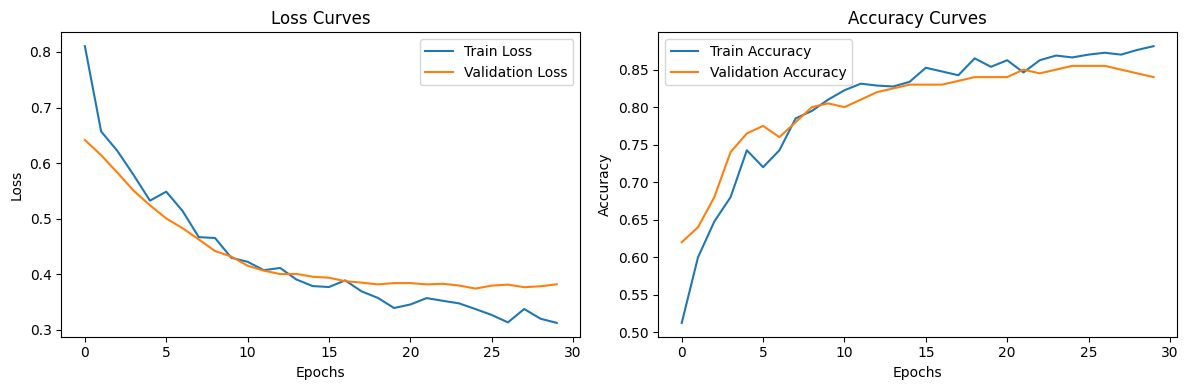

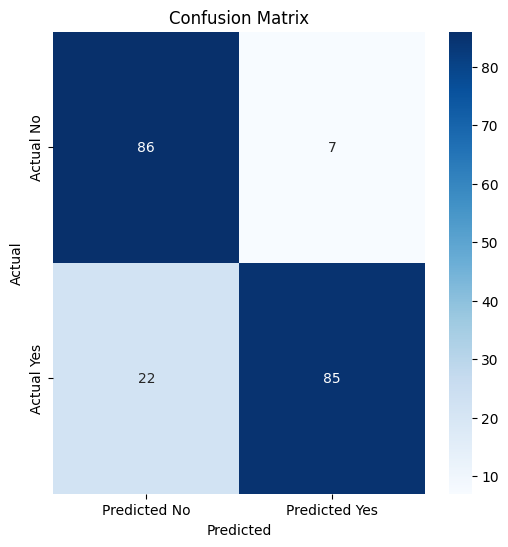

In [19]:
# Plotting loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

# Plotting confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Loss Curves: The loss curves plot the training and validation loss across epochs, allowing you to visualize overfitting or underfitting. The left plot shows the loss over epochs, while the right plot shows the accuracy over epochs.


Confusion Matrix: The confusion matrix is plotted as a heatmap to visually inspect the performance of the classification model. It shows True Positives, True Negatives, False Positives, and False Negatives.

Confusion Matrix: The matrix displays the counts of true positives, true negatives, false positives, and false negatives. The numbers are represented in blue, with darker blue shades indicating higher values.

Assessing the data quality

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [ ]:

# Assuming your dataset is stored in a variable called `data`
num_points = len(data)

# Print the number of points
print(f"The dataset contains {num_points} points.")

The dataset contains 106987 points.
